[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/10HY-s0FvZIHSGG3HHNtu1-qZN7t-qZXz?authuser=1#scrollTo=a4VPOeSJImCQ)

In [ ]:
!pip install openml

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import openml

#Importación del Dataset

In [ ]:
dataset = openml.datasets.get_dataset(560)

<ipython-input-20-343d085db803>:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset(560)


In [ ]:
# Obtener los datos como un DataFrame de Pandas
df_body, df_target, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format='dataframe',
    target=dataset.default_target_attribute
)

In [ ]:
df_body.head(10)

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
5,1.0502,24,210.25,74.75,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8
6,1.0549,26,181.00,69.75,36.4,105.1,90.7,100.3,58.4,38.3,22.9,31.9,27.8,17.7
7,1.0704,25,176.00,72.50,37.8,99.6,88.5,97.1,60.0,39.4,23.2,30.5,29.0,18.8
8,1.0900,25,191.00,74.00,38.1,100.9,82.5,99.9,62.9,38.3,23.8,35.9,31.1,18.2
9,1.0722,23,198.25,73.50,42.1,99.6,88.6,104.1,63.1,41.7,25.0,35.6,30.0,19.2


In [ ]:
x = df_body.values
y = df_target.values

In [ ]:
x.shape, y.shape

((252, 14), (252,))

In [ ]:
y = y.reshape(-1, 1)
y.shape

(252, 1)

#Paso 1: División de los datos en entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 14), (51, 14), (201, 1), (51, 1))

#Paso 2: Implementamos el modelo sin validación cruzada

In [ ]:
k = []
mse = []
r2 = []

for n_neighbors in range(1, 14, 2):
  model = KNeighborsRegressor(n_neighbors)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mse_values = mean_squared_error(y_test, y_pred)
  r2_values = r2_score(y_test, y_pred)
  k.append(n_neighbors)
  mse.append(mse_values)
  r2.append(r2_values)
  print("K = ", n_neighbors, "Error cuadático medio (MSE):", mse_values, "R²", r2_values )

K =  1 Error cuadático medio (MSE): 39.71020000000001 R² 0.48092446899533414
K =  3 Error cuadático medio (MSE): 25.99197777777778 R² 0.6602434722851691
K =  5 Error cuadático medio (MSE): 26.174775999999998 R² 0.6578540085134756
K =  7 Error cuadático medio (MSE): 26.282918367346937 R² 0.6564404156140513
K =  9 Error cuadático medio (MSE): 29.087000000000003 R² 0.6197866046926805
K =  11 Error cuadático medio (MSE): 28.753664462809915 R² 0.6241438308202163
K =  13 Error cuadático medio (MSE): 28.922823668639055 R² 0.6219326507055333


##Gráficamos los resultados para tener una mejor perspectiva.

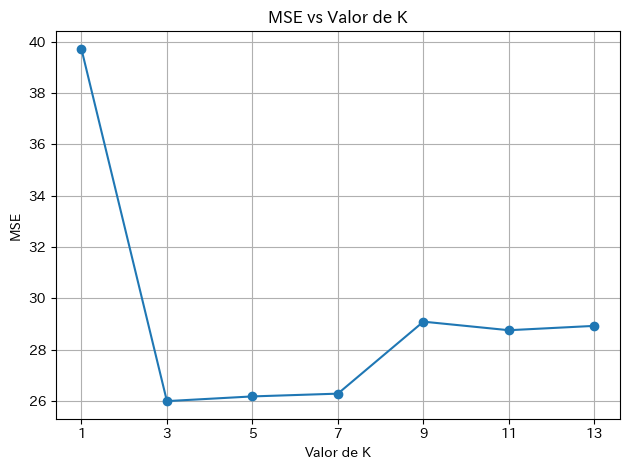

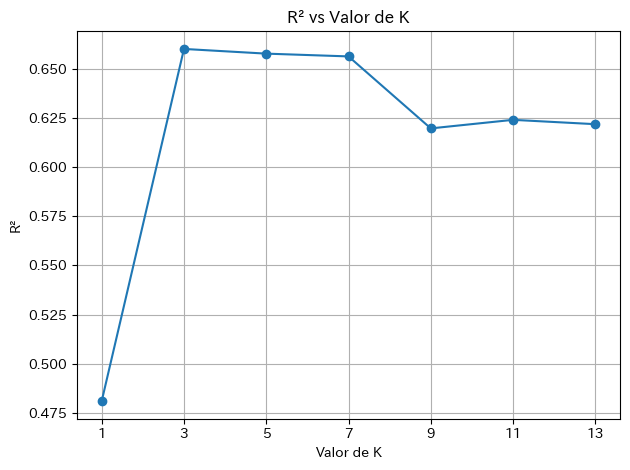

In [ ]:
def plot_metrics_separate(k, metrics, metric_names):
    if len(metrics) != len(metric_names):
        raise ValueError("La cantidad de métricas no coincide con la cantidad de nombres de métricas.")

    for metric, name in zip(metrics, metric_names):
        plt.plot(k, metric, marker='o')
        plt.title(f'{name} vs Valor de K')
        plt.xlabel('Valor de K')
        plt.ylabel(name)
        plt.xticks(k)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_metrics_separate(k, [mse, r2], ['MSE', 'R²'])

#Paso 3: Implementamos la validación cruzada con KFold

In [ ]:
def knn_regression_evaluation(x, y):
    results = []
    num_repetitions = 5
    kf = KFold(n_splits=num_repetitions, shuffle=True, random_state=42)

    for n_neighbors in range(3, 8, 2):
        for repetition, (train_index, test_index) in enumerate(kf.split(x), start=1):
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = KNeighborsRegressor(n_neighbors)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            results.append((n_neighbors, mse, r2, repetition))

    df = pd.DataFrame(results, columns=['k-vecinos', 'Error en conjunto de prueba (MSE)', 'R²', 'Repetición'])
    return df

#Analizamos los resultados

In [ ]:
df_resultados = knn_regression_evaluation(x, y)
df_resultados

,k-vecinos,Error en conjunto de prueba (MSE),R²,Repetición
0,3,24.360871,0.476314,1
1,3,35.001176,0.593363,2
2,3,33.368511,0.408949,3
3,3,33.360756,0.577044,4
4,3,25.991978,0.660243,5
5,5,24.313584,0.477330,1
6,5,32.886094,0.617935,2
7,5,31.141424,0.448397,3
8,5,30.975888,0.607280,4
9,5,26.174776,0.657854,5
